# Homework 6

## ASTR 5900, Fall 2020, University of Oklahoma

### Neural Networks


Imagine a neural network that has already been trained to classify configurations of spins in a lattice as 1 of 2 magnetic phases: ferromagnetic or paramagnetic.  A training set was generated using Monte Carlo at a range of temperatures, and the target classifications were determined for samples generated at temperatures below or above the known critical temperature for the 2D ferromagnetic Ising model with Hamiltonian $$ H = -J\sum_{<i,j>} \sigma^z_i \sigma^z_j $$
where $\sigma^z_k = \{-1, 1 \}$ is the spin at site $k$ and the summation is over adjacent spin sites (share an edge).  This Hamiltonian says there is energy stored between adjacent sites with opposite spins.  Because of this, at low temperatures the spins collectively point in a single direction (either up or down).  As the temperature increases and crosses the critical temperature $T_C$, this behavior suddenly fades and the Ising system becomes disordered with an average magnetization of zero.

### Part A

It's time to generate data with the functions we just defined and apply it to the trained neural net.  As you know, a standard feed forward neural network is a series of layers of connected neurons that fire (or fractionally fire) based on the linear sum of weights and inputs from their respective previous layer.

The neural network in question has 3 layers: the 400 size input layer (because the input is an spin configuration on a $20 \times 20$ lattice), a hidden layer with 3 perceptrons, and an output layer of 2 perceptrons.  The weights (3 $\times $ 400 matrix) and bias (3 $\times $ 1 matrix) of the first layer are:

$$ W_1 = \frac{1}{N(1 + \epsilon)}
 \begin{pmatrix}
  1 & 1 & \cdots & 1 \\
  -1 & -1 & \cdots & -1 \\
  1 & 1 & \cdots & 1
 \end{pmatrix} \; \; \text{and} \; \; b_1 = \frac{1}{1+\epsilon} \begin{pmatrix}
  -1 \\
  -1 \\
  1
 \end{pmatrix}$$
 
 This actually works out to be $$ Wx + b = \frac{1}{1 + \epsilon}\begin{pmatrix}
  m(x) - \epsilon \\
  -m(x) - \epsilon \\
  m(x) + \epsilon
 \end{pmatrix}$$
 
 where $m(x) = \frac{1}{N}\sum_i \sigma^z_i$ is the total magnetization of configuration $x$.  A heaviside step function is applied to each of these elements because they are Perceptrons.
 
The output's weights and biases are:
$$ W_2 = 
 \begin{pmatrix}
  2 & 1 &  -1 \\
      -2 & -2 & 1
 \end{pmatrix} \; \; \text{and} \; \; b_2 =\begin{pmatrix}
  0 \\
    0
 \end{pmatrix}$$

The output features 2 neurons: one that fires if the input is in the cold, ferromagnetic state and the other if the input is in the warm, paramagnetic state.  Write a function that takes a spin configuration (-1's, 1's) and forward propagates that information through layers as precribed above.  That is, manually perform the matrix multiplication and non-linear activation functions until you get an output to 2 nodes.  Use a small but finite value for $\epsilon$.

Use the spin data from a previous homework, `spins.txt`, to determine the critical temperature of the 2D Ising model:
- For every temperature in the dataset, average the output of the final 2 neurons separately.
- Plot these 2 averages as a function of temperature.  At what temperature do these lines cross?  That is interpreted as the critical temperature.

______________________________
### $\textit{Answer:}$

In [2]:
##################################################################
# Standard python initialization
# Execute twice to make sure it takes effect
%pylab inline
import numpy as np
import scipy.stats

fontsize = 8
figsize = (3,3)
dpi = 300

# Configure parameters
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize, 'figure.dpi': dpi})

# Default tick label size
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.linewidth'] = 1

Populating the interactive namespace from numpy and matplotlib


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
########################################
# Read in the data :
temps  = np.loadtxt('spins.txt', usecols = (0))
spins = np.loadtxt('spins.txt', usecols = np.arange(1,401))


We'll start by setting up the matrices given in the problem. W1 is 3x400 matrix where the rows alternate betwee values of +1,-1, and +1: 


In [4]:
epsilon = 1e-12
alpha = len(spins[0])*(1+epsilon)     # Prefactor for w1

w1_row1 = np.zeros(len(spins[0])) + 1 # set all vals to +1 
w1_row2 = np.zeros(len(spins[0])) - 1 # set all vals to -1 
w1_row3 = np.zeros(len(spins[0])) + 1 

# Construct w1:
w1 = (1 /alpha) * np.vstack((w1_row1,w1_row2,w1_row3))

# set up bias 
b1 = (1/(1+epsilon))*np.array([-1,-1,1])

print(w1,w1.shape)
print(b1, b1.shape)

[[ 0.0025  0.0025  0.0025 ...  0.0025  0.0025  0.0025]
 [-0.0025 -0.0025 -0.0025 ... -0.0025 -0.0025 -0.0025]
 [ 0.0025  0.0025  0.0025 ...  0.0025  0.0025  0.0025]] (3, 400)
[-1. -1.  1.] (3,)


Simliarily we can construct W2 as given:

In [5]:
w2_row1 = np.array([2,1,-1])
w2_row2 = np.array([-2,-2,1])

#construct w2
w2 = np.vstack((w2_row1,w2_row2))

# set up bias

b2 = np.array([0,0])

print(w2,w2.shape)


[[ 2  1 -1]
 [-2 -2  1]] (2, 3)


Our next step is to iterate through all 10,000 entries in the spin array and preform the matrix multiplication for each one. Our two output perceptrons should therefore be of length 10,000:

In [6]:
p1 = np.zeros(len(spins))
p2 = np.zeros(len(spins))

print(p1,p1.shape)

[0. 0. 0. ... 0. 0. 0.] (10000,)


In [7]:
################################################
# Begin matrix multiplication 

for i in range(0,len(spins)):
    spin = spins[i,:]                         # select spin
    
    # First transformation
    w1_interm = w1@spin + b1                  # apply first transformation
    w1_interm[np.where(w1_interm < 0)] = 0    # Heaviside step function: Set to zero for negative values 
    w1_interm[np.where(w1_interm > 0)] = 1
    
    
    #Repeat for second transformation 
    w2_interm = w2@w1_interm
    w2_interm[np.where(w2_interm < 0)] = 0 
    w2_interm[np.where(w2_interm > 0)] = 1
    
    # Output is 2d with vals 0 or 1: 
    # First entry for first perceptron, second is for the other
    
    p1[i], p2[i] = w2_interm[0], w2_interm[1]
    

In [8]:
# Inspect
print(p1)
print(p2)


[1. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]


Now that we know which perceptron fires for each temperature measurement, let's average together the results for each unique temperature: 

In [9]:
###########################################
# Get unique temperature entries
temp_list = np.unique(temps)
print(temp_list)

[1.06345927 1.12691853 1.1903778  1.25383706 1.31729633 1.38075559
 1.44421486 1.50767413 1.57113339 1.63459266 1.69805192 1.76151119
 1.82497045 1.88842972 1.95188899 2.01534825 2.07880752 2.14226678
 2.20572605 2.26918531 2.33264458 2.39610385 2.45956311 2.52302238
 2.58648164 2.64994091 2.71340017 2.77685944 2.84031871 2.90377797
 2.96723724 3.0306965  3.09415577 3.15761503 3.2210743  3.28453357
 3.34799283 3.4114521  3.47491136 3.53837063]


In [10]:
##############################################
# Average the p-values for a given temperature 

p1_avg = np.zeros(len(temp_list))           # Null arrays to populate
p2_avg = np.zeros(len(temp_list))

for i, t in enumerate(temp_list):
    here = np.where(temps == t)             # select a temperature
    p1_avg[i] = np.mean(p1[here])
    p2_avg[i] = np.mean(p2[here])

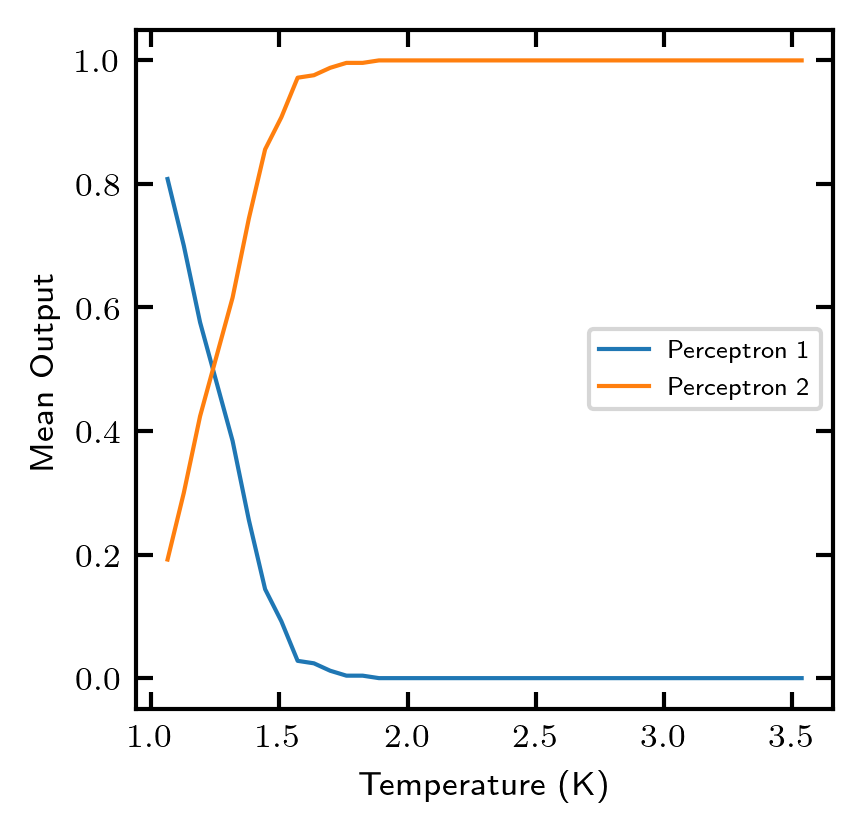

In [11]:
#############################################
# Plot
plt.plot(temp_list,p1_avg, linewidth = 1, label = 'Perceptron 1')
plt.plot(temp_list,p2_avg, linewidth = 1, label = 'Perceptron 2')
plt.xlabel('Temperature (K)')
plt.ylabel('Mean Output')
plt.legend(fontsize = 6)

The two lines cross at a temperature of approximately 1.25 - 1.3 K, implying that this is the critical temperature

### Part B

Train a neural network on conventional software (`sklearn.neural_network.MLPClassifier` or `tensorflow`) to classify spin states as either "ferromagnetic" or "paramagnetic".  Use the same `spins.txt` data to train and test your model (randomly split the data into 2 halves).  Evaluate the model's performance.

You will have to set the labels for the data yourselfs.  Temperatures above 2.269 should be classifed as paramagnetic, and temperatures below should be ferromagnetic.

### $\textit{Answer:}$
We'll start by setting up the classifications:

In [12]:
#####################################################
# Inspect file from earlier
print("Temp info:")
print(temps)
print("Length: " +str(len(temps)))
print("-------------------------------------------")
print("Spin info:")
print(spins)
print("Length: " +str(len(spins)))
print("Dimmensionality: " + str(np.shape(spins)))


Temp info:
[1.06345927 1.06345927 1.06345927 ... 3.53837063 3.53837063 3.53837063]
Length: 10000
-------------------------------------------
Spin info:
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 1.  1.  1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1.  1. -1.]
 [ 1. -1.  1. ... -1. -1.  1.]]
Length: 10000
Dimmensionality: (10000, 400)


In [13]:
#######################################################################
# Assign classifications based on whether T < Tcrit
T_crit = 2.269

labels = np.zeros(len(temps))                  # null array to be populated by classification

                                              
for i in range(0,len(temps)):       
    if temps[i] > T_crit:
        labels[i] = 1                          # Flag entries with T > Tcrit; label as paramagetic
    

In [14]:
################################################################
# Shuffle and split in to training and test set:
from sklearn.model_selection import train_test_split

spin_train, spin_test, label_train, label_test = train_test_split(spins, labels, test_size=0.5, random_state=42)

In [15]:
#####################################################
# Inspect
print("Spin training set:" + str(spin_train))
print("Spin test set: " + str(spin_test))
print("---------------------------------------------")
print("Label training set:" + str(label_train))
print("Label test set: " + str(label_test))


Spin training set:[[ 1.  1.  1. ...  1.  1.  1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [-1. -1.  1. ...  1. -1. -1.]]
Spin test set: [[ 1. -1.  1. ... -1. -1. -1.]
 [-1. -1.  1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [-1. -1. -1. ... -1. -1. -1.]]
---------------------------------------------
Label training set:[1. 0. 0. ... 1. 0. 1.]
Label test set: [1. 0. 0. ... 0. 0. 0.]


We'll use TensorFlow to train our neural net:

In [16]:
#########################################
# Import tensorflow
import tensorflow as tf

Begin setting up the model. We have one of two classifications we need to be able to identify, so we give our second dense layer a size of 2:

In [17]:
########################################
# Setup the model
model= tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(2)
])


In [18]:
########################################
# Compile model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
##########################################
# Train the model
model.fit(spin_train, label_train, epochs=10)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 3s 604us/sample - loss: 0.1461 - accuracy: 0.9422
Epoch 2/10
5000/5000 [==============================] - 1s 224us/sample - loss: 0.0892 - accuracy: 0.9694
Epoch 3/10
5000/5000 [==============================] - 1s 203us/sample - loss: 0.0541 - accuracy: 0.9802
Epoch 4/10
5000/5000 [==============================] - 1s 213us/sample - loss: 0.0390 - accuracy: 0.9852
Epoch 5/10
5000/5000 [==============================] - 1s 184us/sample - loss: 0.0331 - accuracy: 0.9916
Epoch 6/10
5000/5000 [==============================] - 1s 211us/sample - loss: 0.0232 - accuracy: 0.9920
Epoch 7/10
5000/5000 [==============================] - 1s 198us/sample - loss: 0.0200 - accuracy: 0.9924
Epoch 8/10
5000/5000 [==============================] - 1s 212us/sample - loss: 0.0131 - accuracy: 0.9962
Epoch 9/10
5000/5000 [==============================] - 1s 200us/sample - loss: 0.0078 - accuracy: 0.9986
Epoch 10/10
5000/5000 [=

Pretty good accuracy! Let's quantify the preformance a little more:

In [20]:
##############################################
# Evaluate Accuracy
test_loss, test_acc = model.evaluate(spin_test,  label_test, verbose=2)

print('\nTest accuracy:', test_acc)

5000/1 - 1s - loss: 0.0953 - accuracy: 0.9558

Test accuracy: 0.9558


In [21]:
################################################
# Make some predictions
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(spin_test)
print(predictions)

[[1.0212173e-08 1.0000000e+00]
 [9.6341705e-01 3.6583014e-02]
 [9.9999642e-01 3.5796320e-06]
 ...
 [9.9999845e-01 1.5794665e-06]
 [9.9999619e-01 3.7573614e-06]
 [9.9956447e-01 4.3557427e-04]]


Returned by this neural net are the probablities that a given spin configuration belongs to either a dimagnetic (Label = 0) or paramagnetic (Label = 1) material. We see the predicted label for the first three entries in the test set are paramagnetic, diamagnetic, and diamagnetic respectively. Let's check:

In [22]:
print(label_test[:3])

[1. 0. 0.]


Indeed, the neural net looks to be classifying the configurations accurately.